In [2]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [9]:
data = pd.read_csv('../Desktop/4990project/rateData.csv')
print data.head()
print 'Data Types:'
print data.dtypes

     Date  RMBperUSD
0  1/4/07   7.807300
1  1/5/07   7.809700
2  1/6/07   7.810967
3  1/7/07   7.812233
4  1/8/07   7.813500
Data Types:
Date          object
RMBperUSD    float64
dtype: object


In [15]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%m/%d/%y')
data = pd.read_csv('../Desktop/4990project/rateData.csv', parse_dates=True, index_col='Date',date_parser=dateparse)
print data.head()
data.index

            RMBperUSD
Date                 
2007-01-04   7.807300
2007-01-05   7.809700
2007-01-06   7.810967
2007-01-07   7.812233
2007-01-08   7.813500


DatetimeIndex(['2007-01-04', '2007-01-05', '2007-01-06', '2007-01-07',
               '2007-01-08', '2007-01-09', '2007-01-10', '2007-01-11',
               '2007-01-12', '2007-01-13',
               ...
               '2017-02-19', '2017-02-20', '2017-02-21', '2017-02-22',
               '2017-02-23', '2017-02-24', '2017-02-25', '2017-02-26',
               '2017-02-27', '2017-02-28'],
              dtype='datetime64[ns]', name=u'Date', length=3709, freq=None)

In [18]:
ts = data['RMBperUSD']
ts.head(10)

Date
2007-01-04    7.807300
2007-01-05    7.809700
2007-01-06    7.810967
2007-01-07    7.812233
2007-01-08    7.813500
2007-01-09    7.807800
2007-01-10    7.808100
2007-01-11    7.797700
2007-01-12    7.801200
2007-01-13    7.798733
Name: RMBperUSD, dtype: float64

In [23]:
new_period = ts['2015-08-11':]

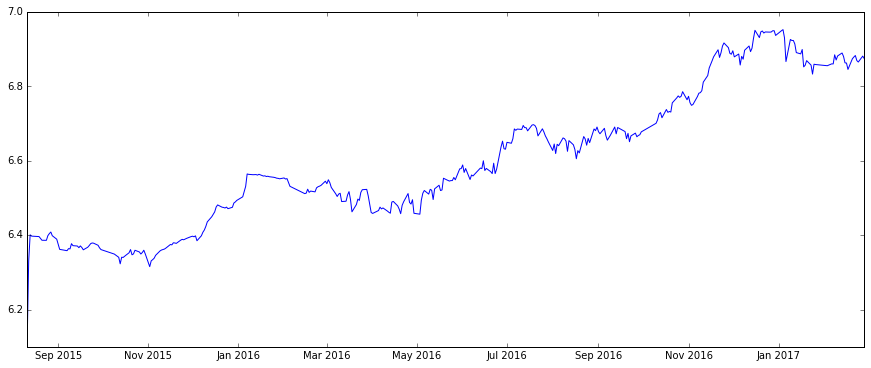

In [24]:
plt.plot(new_period)

### test for stationarity

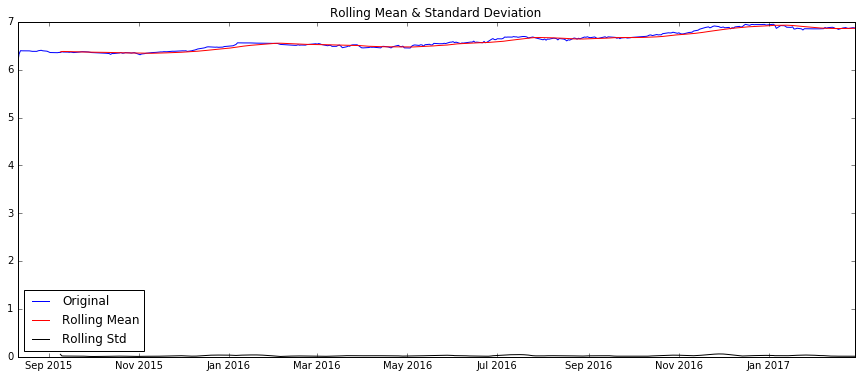

Results of Dickey-Fuller Test:
Test Statistic                  -2.213765
p-value                          0.201288
#Lags Used                       0.000000
Number of Observations Used    567.000000
Critical Value (5%)             -2.866651
Critical Value (1%)             -3.441936
Critical Value (10%)            -2.569492
dtype: float64


In [45]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=30).mean()
    rolstd = timeseries.rolling(window=30).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput
test_stationarity(new_period)

### Towards Stationarity

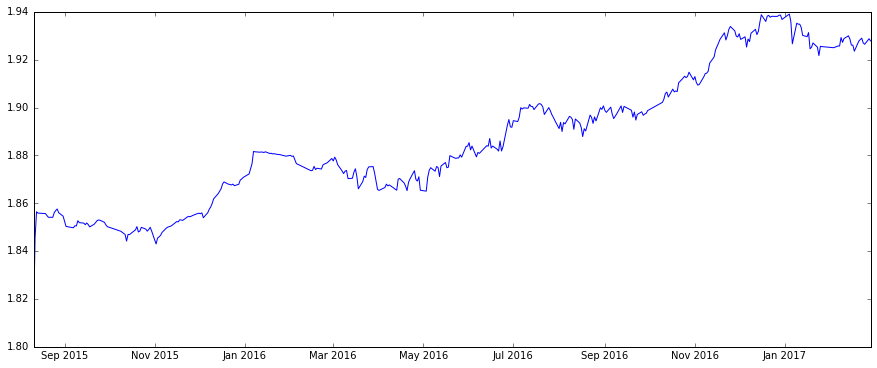

In [61]:
#log transform
new_period_log = np.log(new_period)
plt.plot(new_period_log)

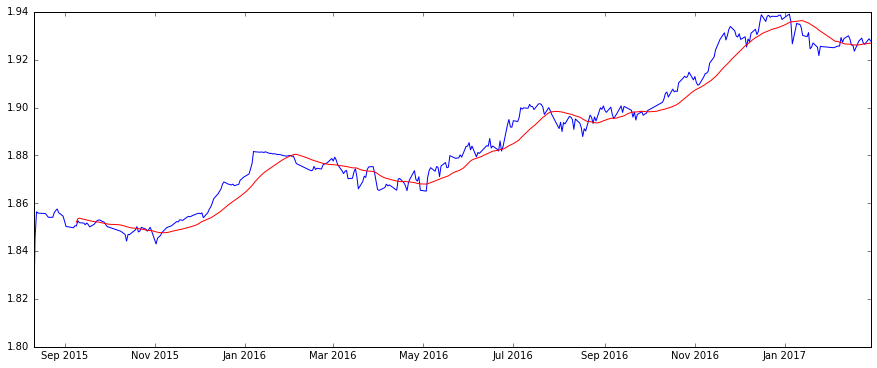

In [33]:
moving_avg = new_period_log.rolling(window=30, center=False).mean()
plt.plot(new_period_log)
plt.plot(moving_avg, color='red')

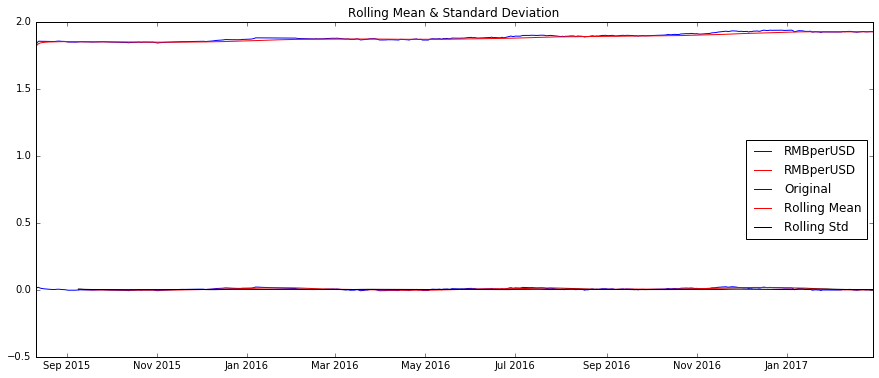

Results of Dickey-Fuller Test:
Test Statistic                  -3.057133
p-value                          0.029893
#Lags Used                       0.000000
Number of Observations Used    567.000000
Critical Value (5%)             -2.866651
Critical Value (1%)             -3.441936
Critical Value (10%)            -2.569492
dtype: float64


In [46]:
expwighted_avg = new_period_log.ewm(halflife=30).mean()
plt.plot(new_period_log)
plt.plot(expwighted_avg, color = 'red')
new_period_log_ewma_diff = new_period_log - expwighted_avg
#print new_period_log_ewma_diff.head(30)
test_stationarity(new_period_log_ewma_diff)


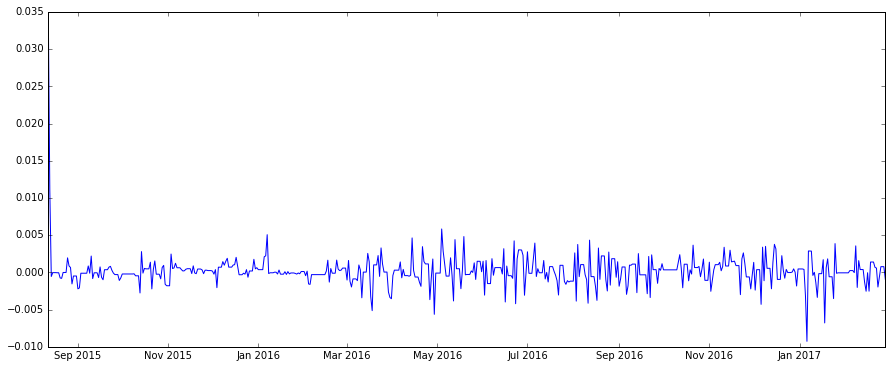

In [42]:
new_period_log_diff = new_period_log - new_period_log.shift()
plt.plot(new_period_log_diff)

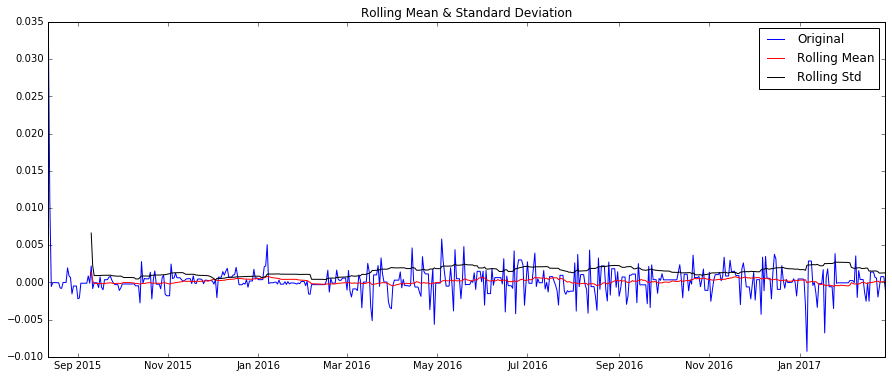

Results of Dickey-Fuller Test:
Test Statistic                 -27.982423
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    566.000000
Critical Value (5%)             -2.866660
Critical Value (1%)             -3.441956
Critical Value (10%)            -2.569497
dtype: float64


In [47]:
new_period_log_diff.dropna(inplace=True)
test_stationarity(new_period_log_diff)

In [48]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

In [53]:
lag_acf = acf(new_period_log_diff, nlags=30)
lag_pacf = pacf(new_period_log_diff, nlags=30, method='ols')

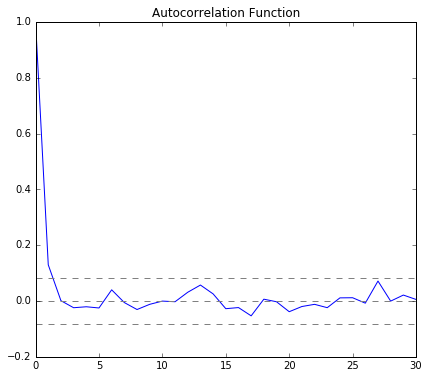

In [59]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(new_period_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(new_period_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')


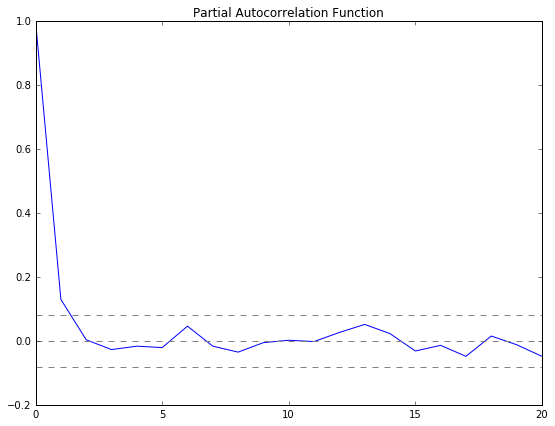

In [52]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(new_period_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(new_period_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

/Users/liang/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Date
2015-08-12    0.000215
2015-08-13    0.008095
2015-08-14    0.002864
2015-08-15   -0.000789
2015-08-16    0.000012
dtype: float64


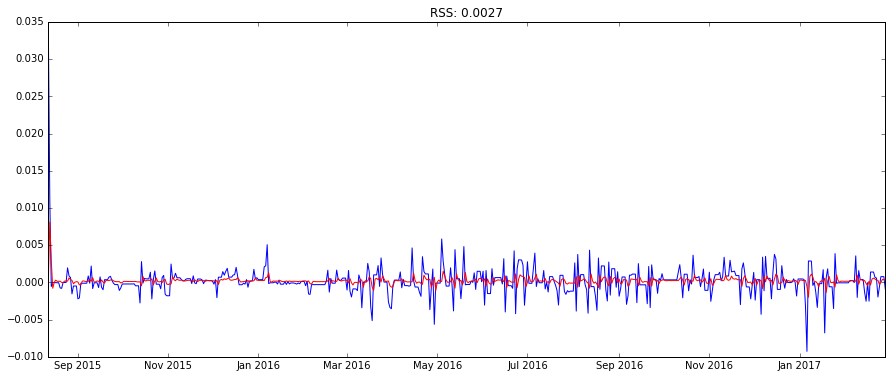

In [90]:
#ARIMA Model
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(new_period_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(new_period_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-new_period_log_diff)**2))

print results_ARIMA.fittedvalues.head()

# Forecasting Next 5 Days' Rates

In [155]:
#This method uses statmodel forecasting with confident interval 0.05
out_Sample_Prediction = results_ARIMA.forecast(steps = 5, exog = None, alpha = 0.05)
predictions = np.exp(out_Sample_Prediction[0])
print predictions

[ 6.87462629  6.87551668  6.87709126  6.87860909  6.88008596]


In [64]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print predictions_ARIMA_diff.head()


Date
2015-08-12    0.000215
2015-08-13    0.008095
2015-08-14    0.002864
2015-08-15   -0.000789
2015-08-16    0.000012
dtype: float64


In [65]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print predictions_ARIMA_diff_cumsum.head()


Date
2015-08-12    0.000215
2015-08-13    0.008310
2015-08-14    0.011174
2015-08-15    0.010385
2015-08-16    0.010397
dtype: float64


In [152]:
predictions_ARIMA_log = pd.Series(new_period_log.ix[0], index=new_period_log.index)
#print new_period_log.ix[0]
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

Date
2015-08-11    1.810941
2015-08-12    1.811156
2015-08-13    1.819251
2015-08-14    1.822115
2015-08-15    1.821326
dtype: float64

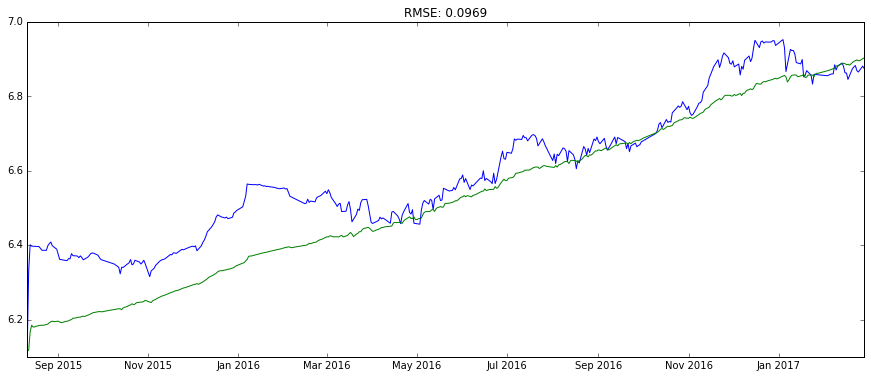

In [151]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
#print predictions_ARIMA
plt.plot(new_period)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-new_period)**2)/len(new_period)))

# Prediction Next 100 Days

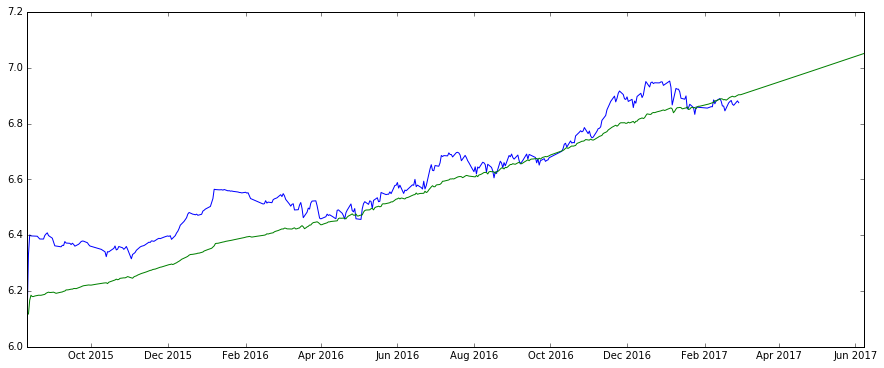

In [156]:
#this method is easy to plot. However it has different value than forecasting even though they come from same library.
from pandas.tseries.offsets import *
import statsmodels.api as sm
start = new_period.index[-1] + Day(1)
end = new_period.index[-1] + Day(100)

##dynamic_Sample_Prediction is error is future
dynamic_Sample_Prediction = results_ARIMA.predict(start.isoformat(), end.isoformat(), exog = None, dynamic = False)

## dynamic_Sample_Prediction_log is error data with future error
dynamic_Sample_Prediction_log = dynamic_Sample_Prediction.add(predictions_ARIMA_diff,fill_value=0)

## dynamic_Sample_Prediction_log_cumsum is cumulate sum of all errors
dynamic_Sample_Prediction_log_cumsum = dynamic_Sample_Prediction_log.cumsum()

## expand 1.81094 to date + future date
dynamic_ARIMA_log = pd.Series(new_period_log.ix[0], index=dynamic_Sample_Prediction_log.index)

## add 1.81094 to all cumsum respectively
dynamic_ARIMA_log = dynamic_ARIMA_log.add(dynamic_Sample_Prediction_log_cumsum,fill_value=0)

## back to original data
dynamic_Sample_Prediction_ARIMA = np.exp(dynamic_ARIMA_log)

#print dynamic_ARIMA_log
plt.plot(new_period)
plt.plot(dynamic_Sample_Prediction_ARIMA)
